# **Drive Mounting**


In [1]:
from google.colab import drive

drive.mount('/content/drive')


# !kill -9 -1

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Import** 

In [2]:
import numpy as np
import os
from os import listdir
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
# import matplotlifrom __future__ import print_function, division

from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Add
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.utils import plot_model
from functools import partial
import keras.backend as K

Using TensorFlow backend.


# **Model**

In [0]:
class DenoiseNet():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.filters = 63
        self.layers = 20
#         self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.img_shape = (None, None, self.channels)
        baseFolder = os.getcwd()
        baseFolder += '/drive/My Drive/Project/'
        self.weights_dir = baseFolder + '/Weights/'


        # Following parameter and optimizer set as recommended in paper
        self.opt = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)

        # Build DenoiseNet model
        self.model = self.build_model()

        # save and print model summary
        self.model.summary()
        plot_model(self.model, to_file='DenoiseNet_model.png', show_shapes=True)

        # compile the model
        self.model.compile(loss='mean_squared_error', optimizer=self.opt)
        # self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

    def build_model(self):

        net = {}
        net['Input'] = Input(shape=self.img_shape, name='Input')

        # convolution 1
        # c1 = Conv2D(filters=self.filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        # residual calculation
        # res = Add()([x, c1])
        for layer in range(self.layers):
            if layer == 0:
                # convolution
                net['conv_%d'%(layer+1)] = Conv2D(filters=self.filters, kernel_size=(3, 3), strides=(1, 1),
                                                padding='same', activation='relu')(net['Input'])
                # convolution residual
                net['conv_res_%d' % (layer + 1)] = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1),
                                                      padding='same')(net['conv_%d'%(layer+1)])
                # input residual
                net['input_residual'] = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1),
                                                          padding='same')(net['Input'])
                # residual calculation
                net['residual'] = Add()([net['input_residual'], net['conv_res_%d' % (layer + 1)]])
            else:
                # convolution
                net['conv_%d' % (layer + 1)] = Conv2D(filters=self.filters, kernel_size=(3, 3), strides=(1, 1),
                                                      padding='same', activation='relu')(net['conv_%d'%(layer)])
                # convolution residual
                net['conv_res_%d' % (layer + 1)] = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1),
                                                          padding='same')(net['conv_%d' % (layer + 1)])
                # residual calculation
                net['residual'] = Add()([net['residual'], net['conv_res_%d' % (layer + 1)]])

        net['Output'] = Add()([net['residual'], net['Input']])


        return Model(net['Input'], net['Output'])

    # create matrix of 128x128 patches croped from all images

    def data_generator(self, x, y, rows, cols):
        data_shape = np.shape(x)
        cropped_x = np.zeros((data_shape[0], rows, cols, 1))
        cropped_y = np.zeros((data_shape[0], rows, cols, 1))
        for image in range(data_shape[0]):
            image_shape = np.shape(x[image])
            if image_shape[0] <= rows:
                row = 0
            else:
                row = np.random.randint(low=0, high=image_shape[0] - rows - 1)
            if image_shape[1] <= cols:
                col = 0
            else:
                col = np.random.randint(low=0, high=image_shape[1] - cols - 1)
            x_temp = x[image]
            cropped_x[image, :, :, :] = x_temp[row:row + rows, col:col + cols, :]
            # plt.figure()
            # plt.imshow(cropped_x[image, :, :, 0])
            y_temp = y[image]
            cropped_y[image, :, :, :] = y_temp[row:row + rows, col:col + cols, :]
            # plt.figure()
            # plt.imshow(cropped_y[image, :, :, 0])
            
        return cropped_x, cropped_y

    def load_w(self, path):
    #     the function get weights path and load model pre-trained weights
        self.model.load_weights(path)

    def train_model(self, x_train, y_train, x_test, y_test, epochs=100, batch_size=64, print_period=1, save_period=10, sigma='10'):

        train_loss = np.zeros(epochs)
        test_loss = np.zeros(epochs)
        data_shape = np.shape(x_test)
        
        for epoch in range(epochs):
            
            temp_loss = 0
            # create random patches from data for the current epoch
            (x_train_patches, y_train_patches) = self.data_generator(x_train, y_train, self.img_rows, self.img_cols)
            
            # train the model
            # loss = self.model.fit(x_train_patches,
            #                     shuffle=True,
            #                     epochs=1,
            #                     batch_size=params['BATCH_SIZE'],
            #                     validation_data=(x_test, None),
            #                     callbacks=[TensorBoard(log_dir=Tensorboard_Logs_dir)],
            #                     verbose=0)
            loss = self.model.fit(x=x_train_patches, y=y_train_patches, batch_size=batch_size, epochs=1, verbose=0)
            train_loss[epoch] = loss.history['loss'][0]
#             for image in range(data_shape[0]):
#                 data = np.expand_dims(a=x_test[image], axis=0)
#                 gt = np.expand_dims(a=y_test[image], axis=0)
#                 temp_loss += self.model.evaluate(x=data, y=gt, verbose=0)/data_shape[0]
         
            test_loss[epoch] = temp_loss
            
            if (epoch % print_period == 0):
                print("Epoch #: %d, Train Loss: %f" % (epoch, train_loss[epoch]))

            # Save Weights
            if (epoch % save_period == 0) & (epoch > 0):
                self.model.save_weights(filepath=self.weights_dir + 'Sigma_' + sigma + '_Epoch_' + str(epoch), overwrite=True)
        #  save model at the end of the training
        self.model.save_weights(filepath=self.weights_dir + 'Sigma_' + sigma + '_Trained', overwrite=True)
        return train_loss, test_loss
      
    def denoise_image(self, noised_images, gt_images):
        data_shape = np.shape(noised_images)
        denoised_images = []
        psnr = []
        for image in range(data_shape[0]):
            data = np.expand_dims(a=noised_images[image], axis=0)
            denoised_data = self.model.predict(data)
            denoised_images.append(denoised_data[0, :, :, :])
            mse = (np.square(gt_images[image] - denoised_images[-1])).mean(axis=None)
            psnr.append(10.0 * np.log10(1.0 / mse) / np.log10(10.0))
        return denoised_images, psnr



# **Main**

Text(0.5, 1.0, 'Noised image')

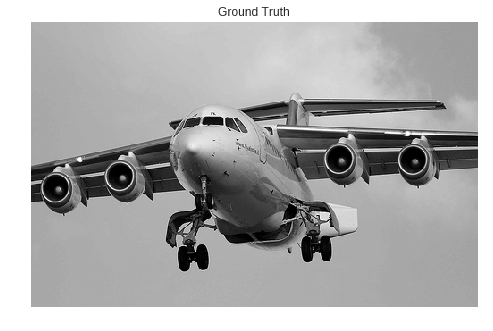

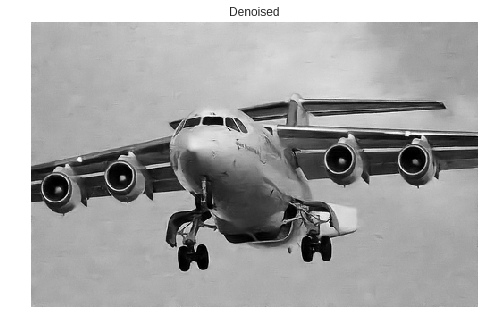

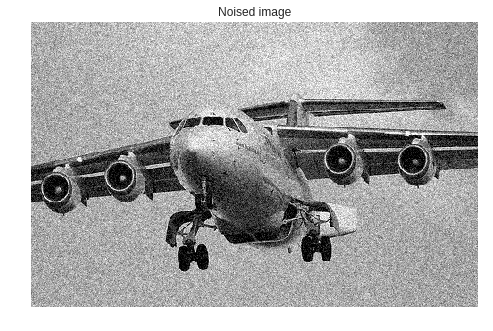

In [8]:
# Parameters
baseFolder = os.getcwd()
baseFolder += '/drive/My Drive/Project'
train_dir = baseFolder + '/Train_real_1/'
test_dir = baseFolder + '/test/'
weights_path = baseFolder + '/Weights/Sigma_25_Trained_GL'
noise_sigma = 25
load_weights_flag = 1
train_or_test = 0
# channel = 2
mode = 1
gt_suf = 'Reference'
noise_suf = 'Noisy'
im_type = 'jpg' 
  
def rgb2y(rgb_img):
    return rgb_img[:, :, 0:1]*0.299 + rgb_img[:, :, 1:2]*0.587 + rgb_img[:, :, 2:3]*0.114

def return_channel(rgb_img, channel):  
    return rgb_img[:, :, channel]

# read images from a path, create a list that stores the images and a second list with the corresponding noisy images

def read_images(path, mode, noise_sigma, channel, gt_suf, noise_suf, im_type):
    # the function get a path to images directory, load all images in the directory and noise them, and then return the
    # loaded images and noised images
    # inputs:  path - a path to the directory with the images
    #          mode - a flag, if 1 a i.i.d gaussian noise will be added to the images, if 0 images will be loaded to
    #                 ground truth and noisy images according to the gt_suf, noise_suf strings
    #          gt_suf - ground truth suffix, a string
    #          noise_suf - noisy image suffix
    #          noise_sigma - the added gaussian noise sigma
    #
    # outputs: x - noised images array
    #          y - same images without noise

    img_list = [f for f in listdir(path) if re.search(r'[.]*\.%s$' % im_type, f)]
    img_list.sort()
    x = []
    y = []
    if mode == 1:
        for img in img_list:
            im_path = path + img
            # rgb_img = cv2.imread(im_path)
#             rgb_img = mpimg.imread(im_path)
            rgb_img = misc.imread(im_path, mode ='L')
#             rgb_img = rgb_img.astype(np.float32)
            gt = rgb_img.astype(np.float32)
#             gt = return_channel(rgb_img, channel)
#             gt = rgb2y(rgb_img)
            
            # gt = gt[:, :, 0]
            gt = gt.astype(np.float32) * (1.0 / 255.0) - 0.5
            noisy = gt + np.random.normal(size=gt.shape) * float(noise_sigma) / 255.0


            gt = np.expand_dims(a=gt, axis=2)
            noisy = np.expand_dims(a=noisy, axis=2)
            x.append(gt)
            y.append(noisy)
    elif mode == 0:
        for img in img_list:
            im_path = path + img
#             rgb_img = mpimg.imread(im_path)
            rgb_img = misc.imread(im_path, mode ='L')
#             rgb_img = rgb_img.astype(np.float32)
            gt = rgb_img.astype(np.float32)
#             gt = return_channel(rgb_img, channel)
            gt = gt.astype(np.float32) * (1.0 / 255.0) - 0.5
            gt = np.expand_dims(a=gt, axis=2)
            if img.find(gt_suf) != -1:
                x.append(gt)
            elif img.find(noise_suf) != -1:
                y.append(gt)

    else:
        print('Wrong mode')
    return x, y

# create DenoisNet class instanse
denoise_model = DenoiseNet()

if load_weights_flag == 1:
  denoise_model.load_w(weights_path)
  
# main functions
if train_or_test==1:
  (x, y) = read_images(train_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
  (x_test, y_test) = read_images(test_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
  # train the network
  if mode == 1:
    sigma = str(noise_sigma)
  elif mode == 0:
    sigma = 'Real_noise' 
  (train_loss, test_loss) = denoise_model.train_model(y, x, x_test, y_test, epochs=100, batch_size=64, print_period=1, save_period=50, sigma=sigma)
  plt.figure()
  plt.plot(range(np.shape(train_loss)[0]),train_loss, 'b')
  plt.plot(range(np.shape(test_loss)[0]),test_loss, 'r')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.legend(['Training Set', 'Test Set'])
  plt.show()
else:
  #  test denoising
  (x_test, y_test) = read_images(test_dir, mode, noise_sigma, 0, gt_suf, noise_suf, im_type)
  (denoised_y, psnr) = denoise_model.denoise_image(y_test, x_test)    
  print(psnr)
  d = x_test[0]
  g = denoised_y[0]
  k = y_test[0]
  d = np.array(np.clip((d + 0.5) * 255.0, 0, 255), dtype=np.uint8)
  g = np.array(np.clip((g + 0.5) * 255.0, 0, 255), dtype=np.uint8)
  k = np.array(np.clip((k + 0.5) * 255.0, 0, 255), dtype=np.uint8)
  plt.figure()
  plt.imshow(d[:,:,0], cmap='gray')
  plt.axis('off')
  plt.title('Ground Truth')
  plt.figure()
  plt.imshow(g[:,:,0], cmap='gray')
  plt.axis('off')
  plt.title('Denoised')
  plt.figure()
  plt.imshow(k[:,:,0], cmap='gray')
  plt.axis('off')
  plt.title('Noised image')
  

